In [271]:
def adam_peer(x, y, w, b, alpha, momentw, momentb, sqw, sqb, beta1, beta2, epsilon, momentum_guidance_w, momentum_guidance_b, guidance_w, guidance_b, gradientw_max, gradientb_max):
    dl_dw = 0
    dl_db = 0
    N = len(x)
    
    mw, mb = momentw, momentb
    sw, sb = sqw, sqb
    
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
    gradientw_current = (1/float(N))*dl_dw
    gradientb_current = (1/float(N))*dl_db
    
    #mw = (beta1*mw) - ((1 - beta1)*(gradientw_current))
    #mw = ((guidance_w-0.00000001)*mw) - ((1 - (guidance_w-0.00000001))*(gradientw_current))
    #mw = guidance_w*((beta1*mw) - ((1 - beta1)*(gradientw_current)))
    
    mw = (((1-guidance_w)*mw) - ((guidance_w)*(gradientw_current))) #XXXXXXXXXXXXXXXit works somewhat good
    #mb = (beta1*mb) - ((1 - beta1)*(gradientb_current))
    #mb = ((guidance_b-0.00000001)*mb) - ((1 - (guidance_b-0.00000001))*(gradientb_current))
    mb = guidance_b*((beta1*mb) - ((1 - beta1)*(gradientb_current)))
    #mb = (((1-guidance_b)*mb) - ((guidance_b)*(gradientb_current))) #XXXXXXXXXXXXXXXXXXXit works somewhat good
    
    sw= (beta2*sw) + ((1 - beta2)*(gradientw_current)**2)
    #sw = guidance_w*((beta2*sw) + ((1 - beta2)*(gradientw_current)**2))
    sb = (beta2*sb) + ((1 - beta2)*(gradientb_current)**2)
    #sb = guidance_b*((beta2*sb) + ((1 - beta2)*(gradientb_current)**2))
    
    mw_hat = mw / (1 - beta1)
    mb_hat = mb / (1 - beta1)
    
    sw_hat = sw / (1 - beta2)
    sb_hat = sb / (1 - beta2)
    
    #w = w + (alpha*((guidance_w*momentum_guidance_w) + mw_hat)) / np.sqrt(sw_hat + epsilon)
    w = w + (alpha*((guidance_w*(momentum_guidance_w / (1 - beta1))) + mw_hat)) / np.sqrt(sw_hat + epsilon)
    #the problem is in any of these guidance_w, momentum_guidance_w, mw_hat, sw_hat
    #b = b + (alpha*((guidance_b*momentum_guidance_b) + mb_hat)) / np.sqrt(sb_hat + epsilon)
    b = b + (alpha*((guidance_b*(momentum_guidance_b / (1 - beta1))) + mb_hat)) / np.sqrt(sb_hat + epsilon)
    
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
    gradientw = (1/float(N))*dl_dw
    gradientb = (1/float(N))*dl_db
    
    if gradientw > gradientw_max:
        gradientw_max = gradientw
    if gradientb > gradientb_max:
        gradientb_max = gradientb
    
    return w, b, mw, mb, sw, sb, gradientw_max, gradientb_max, gradientw, gradientb

In [272]:
def momentum_peer(x, y, w, b, alpha, momentw, momentb, beta):
    dl_dw = 0
    dl_db = 0
    N = len(x)
    mw, mb = momentw, momentb
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
        
    mw = beta*mw - alpha*(1/float(N))*dl_dw
    mb = beta*mb - alpha*(1/float(N))*dl_db
    
    w = w+mw
    b = b+mb
    
    return w, b, mw, mb

In [273]:
def guidance_decay(gradientw, gradientb, max_gradient_w, max_gradient_b):
    #guidance_w = 1 - (np.exp(-abs(gradientw)))
    guidance_w = 1 - (np.exp(-abs(((max_gradient_w - gradientw)  / max_gradient_w))*10))
    
    #guidance_w = 1 - (np.exp(-abs(abs(max_gradient_w) - abs(gradientw)) / abs(max_gradient_w)))
    #guidance_b = 1 - (np.exp(-abs(gradientb)))
    guidance_b = 1 - (np.exp(-abs(((max_gradient_b - gradientb) / max_gradient_b))*10))
    
    #guidance_b = 1 - (np.exp(-abs(abs(max_gradient_b) - abs(gradientb)) / abs(max_gradient_b)))
    return guidance_w, guidance_b

In [276]:
from matplotlib.pyplot import figure
import time
def train(x, y, w1, b1, w2, b2, alpha, epochs, beta1, beta2, epsilon):
    avg_loss_list = []
    w_list = []
    b_list = []
    img_list = []
    pred_val_at_diff_epoch = []
    mw1, mb1, mw2, mb2 = 0, 0, 0, 0
    sqw1, sqb1, sqw2, sqb2 = 0, 0, 0, 0
    guidance_w2, guidance_b2 = 1, 1
    gradientw_max, gradientb_max = 0.00000001, 0.00000001
    for num_of_epochs in range(epochs):
        xy = pd.concat([x, y], axis = 1)
        indexes = xy.index
        rand_indexes = np.random.choice(indexes, 15)
        xtrain = []
        ytrain = []
        for i in rand_indexes:
            xtrain.append(x[i])
            ytrain.append(y[i])
        w1, b1, mw1, mb1 = momentum_peer(x, y, w1, b1, alpha, mw1, mb1, 0.9)
        #gradientw1 = (671 - gradientw1) / 671 #not correct, 671 is cost not gradient replace with 1/N*dl_dw
        #gradientb1 = (671 - gradientb1) / 671 #not correct, above eq
        w2, b2, mw2, mb2, sw2, sb2, gradientw_max, gradientb_max, gradientw2, gradientb2 = adam_peer(xtrain, ytrain, w2, b2, alpha, mw2, mb2, sqw2, sqb2, beta1, beta2, epsilon, mw1, mb1, guidance_w2, guidance_b2, gradientw_max, gradientb_max)
        guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2, gradientw_max, gradientb_max)
        #guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2)
        #w2, b2, mw2, mb2, sw2, sb2, gradientw2, gradientb2 = adam_peer(xtrain, ytrain, w2, b2, alpha, mw2, mb2, sqw2, sqb2, beta1, beta2, epsilon, mw1, mb1, guidance_w1, guidance_b1)
        #guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2)
        
        if num_of_epochs%10 == 0:
            avg_loss_val1 = avg_loss(x, y, w1, b1)
            avg_loss_val2 = avg_loss(x, y, w2, b2)
            if avg_loss_val1 < avg_loss_val2:
                avg_loss_list.append(avg_loss_val1)
                w, b = w1, b1 
            elif avg_loss_val1 >= avg_loss_val2:
                avg_loss_list.append(avg_loss_val2)
                w, b = w2, b2
            w_list.append(w)
            b_list.append(b)
        if num_of_epochs%5000 == 0:
            print("epoch: ", num_of_epochs,"average loss: ",avg_loss_val2)
            print(f"Momentum leader: gradient_w2 = {gradientw2}, gradient_b2 = {gradientb2}, MAX_w_gradient = {gradientw_max} and b = {gradientb_max}")
            print(f"Momentum leader: mw1 = {mw1}, mb1 = {mb1}")
            print(f"Momentum leader: guidance_w2 = {guidance_w2}, guidance_b2 = {guidance_b2}")
            #print(f"Adam follower: w2 = {w2}, b2 = {b2}")
            print(f"Adam follower: mw2 = {mw2}, mb2 = {mb2}, sw2 = {sw2}, sb2 = {sb2}")
            
            figure(figsize = (15, 10))
            plt.title(f"Epoch: {num_of_epochs}")
            plt.xlabel("X")
            plt.ylabel("y")
            plt.xlim(0, 9)
            plt.ylim(0, 50)
            
            plt.scatter(x, y)
            xt = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
            yt = []
            for i in range(10):
                yt.append(predict(xt[i], w2, b2))
                
            plt.plot(xt, yt, color = "red")
            
            plt.savefig(f"{num_of_epochs}.png")
            img_list.append(f"{num_of_epochs}.png")
            
            plt.show()
            
            if avg_loss(x, y, w2, b2) <= 38:
                return w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch
            print(avg_loss_val1, w1, b1)
            print(avg_loss_val2, w2, b2)
    return w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch

In [277]:
def avg_loss(x, y, w, b):
    N = len(x)
    total_error = 0
    for i in range(N):
        total_error += (y[i] - (w*x[i]+b))**2
    return total_error/float(N)

In [278]:
def predict(x, w, b):
    return w*x+b

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
dataset = load_boston()
df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
df["Y"] = dataset.target
X = pd.concat((df["LSTAT"], df["RM"]), axis = 1)
y = pd.DataFrame(df["Y"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

epoch:  0 average loss:  668.2950628047643
Momentum leader: gradient_w2 = -518.0996058933206, gradient_b2 = -83.37263867879507, MAX_w_gradient = 1e-08 and b = 1e-08
Momentum leader: mw1 = 0.31688613697270474, mb1 = 0.04843027295285366
Momentum leader: guidance_w2 = 1.0, guidance_b2 = 1.0
Adam follower: mw2 = 259.4138, mb2 = 4.174666666666665, sw2 = 672.9551963044005, sb2 = 17.42784177777779


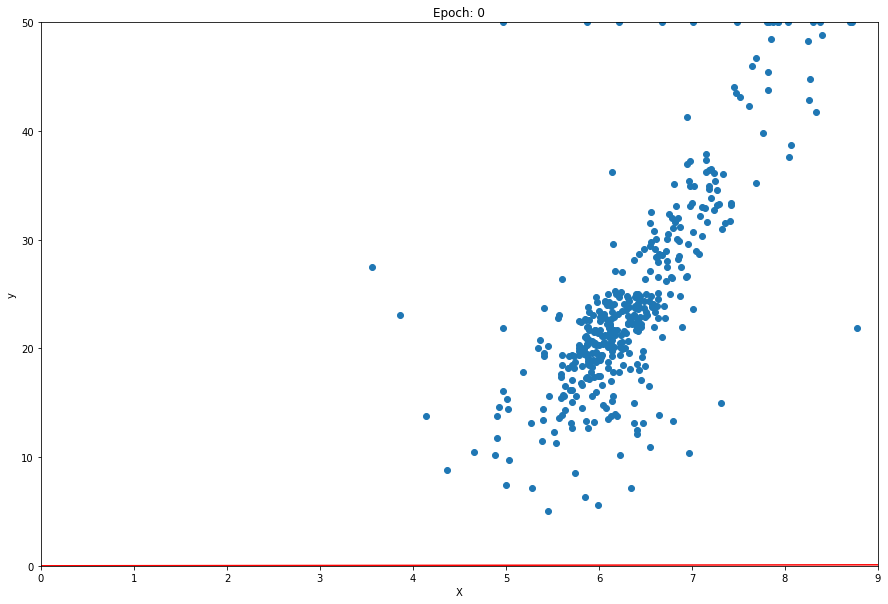

573.0312769351891 0.31688613697270474 0.04843027295285366
668.2950628047643 0.0100122154695232 0.0010116009915757812
epoch:  5000 average loss:  47.05438085576846
Momentum leader: gradient_w2 = 42.084228681166124, gradient_b2 = 7.903379863734693, MAX_w_gradient = 171.2834148070416 and b = 27.64392191797879
Momentum leader: mw1 = 0.0004009151469973501, mb1 = -0.0025729557630329533
Momentum leader: guidance_w2 = 0.9994701974713209, guidance_b2 = 0.9992080452478413
Adam follower: mw2 = -21.446264912191857, mb2 = -0.8727788108655001, sw2 = 4.59974490605523, sb2 = 0.16129060779888485


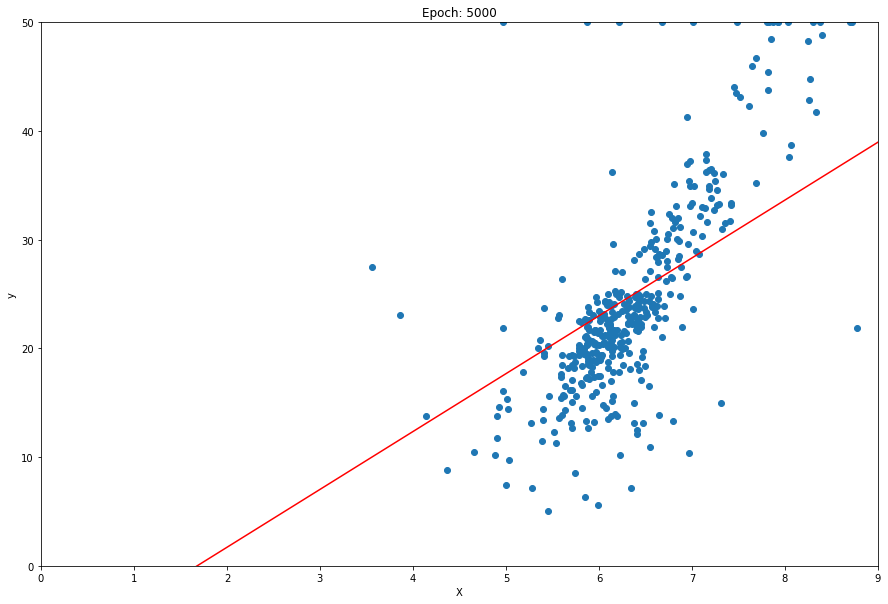

39.074896318437354 7.863978252555039 -25.479180120384243
47.05438085576846 5.323042574959278 -8.943783326858906
epoch:  10000 average loss:  39.17149971074463
Momentum leader: gradient_w2 = -71.2345355720269, gradient_b2 = -10.041390553181854, MAX_w_gradient = 171.2834148070416 and b = 27.64392191797879
Momentum leader: mw1 = 0.00011110549758259482, mb1 = -0.0007130424790657173
Momentum leader: guidance_w2 = 0.9999992906164038, guidance_b2 = 0.9999987990581927
Adam follower: mw2 = 36.05834521594638, mb2 = 0.7904645485353619, sw2 = 13.002183558564912, sb2 = 0.2588484115734386


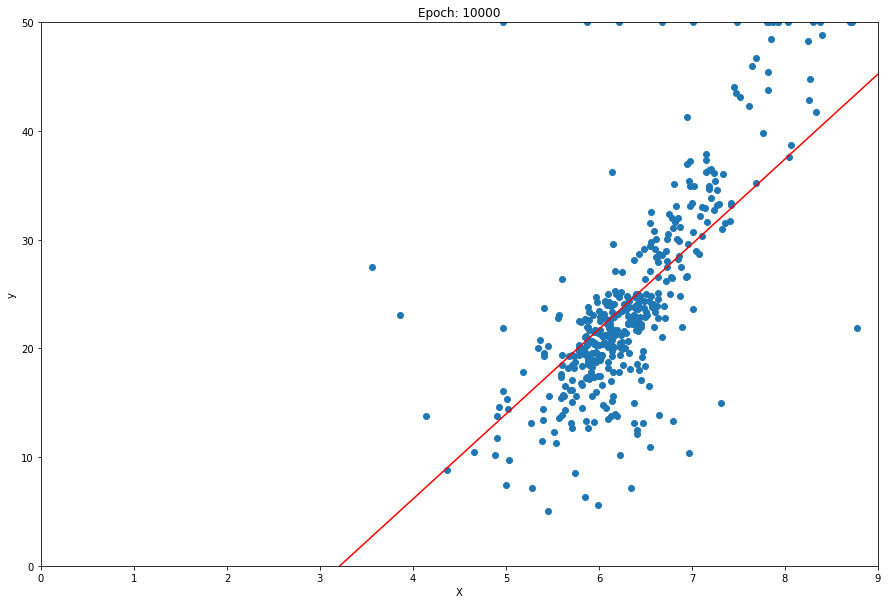

37.85862922877691 8.993017916023055 -32.72502535862717
39.17149971074463 7.817101130971903 -25.126647789907235
epoch:  15000 average loss:  37.89296564677679
Momentum leader: gradient_w2 = 18.17929375831661, gradient_b2 = 4.503983882735831, MAX_w_gradient = 184.79368246623878 and b = 29.733653939882487
Momentum leader: mw1 = 3.0790634091764076e-05, mb1 = -0.00019760525394845333
Momentum leader: guidance_w2 = 0.9998785779848781, guidance_b2 = 0.9997935027675339
Adam follower: mw2 = -9.513008634223464, mb2 = -0.29879879305999923, sw2 = 0.9043983487748198, sb2 = 0.053693218366782675


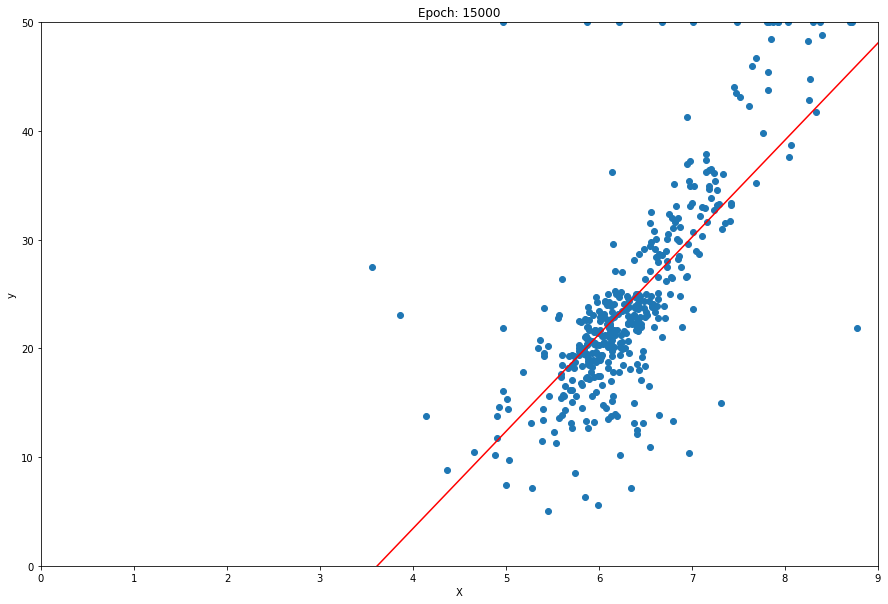

292.963595867157


In [280]:
start_time = time.time()
w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch = train(df["RM"][0:403], df["Y"][0:403], 0, 0, 0, 0, 0.001, 1000000, 0.9, 0.99, 0.0000001)
print(f"{time.time() - start_time}")

In [285]:
print(len(w_list))
print(len(b_list))
print(len(avg_loss_list))
print("best value for w: ",w)
print("best value for b: ",b)
print(len(img_list))
print(len(pred_val_at_diff_epoch))

1501
1501
1501
best value for w:  9.305908348174802
best value for b:  -34.73306433303717
4
0


In [286]:
len(avg_loss_list)*10

15010

In [287]:
min(avg_loss_list)

37.75998152071155

In [288]:
n = np.linspace(10, 15010, 1501, endpoint = True)
len(n)

1501

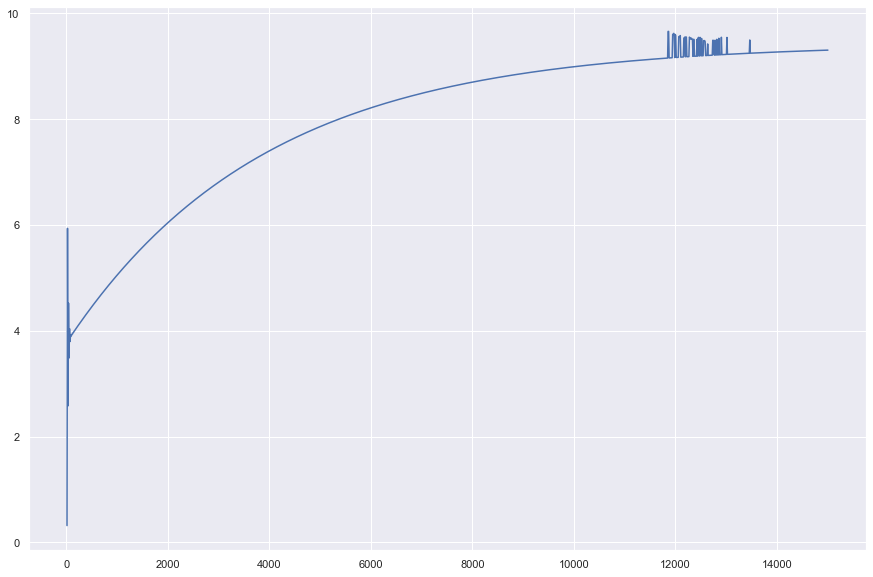

In [289]:
sns.set(rc = {"figure.figsize" : (15, 10)})
plt.plot(n, w_list)
plt.show()

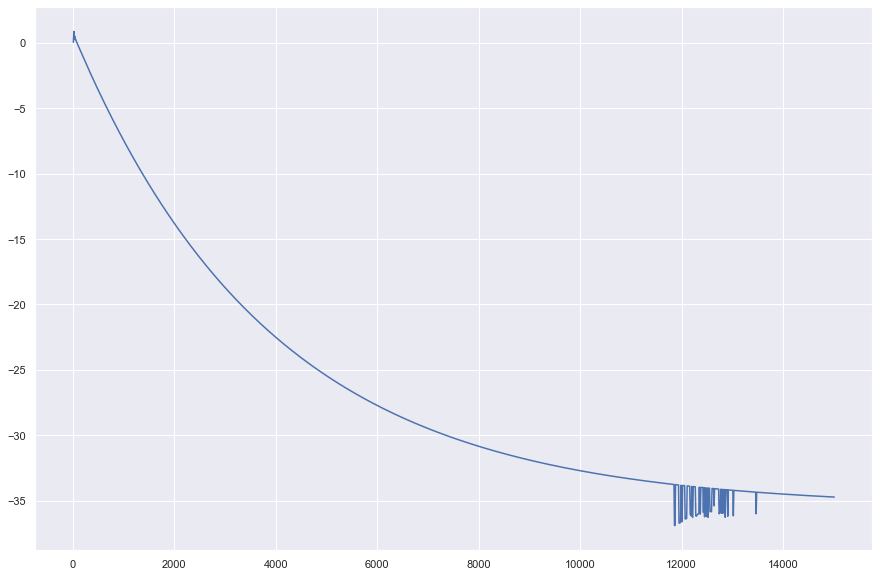

In [290]:
plt.plot(n, b_list)
plt.show()

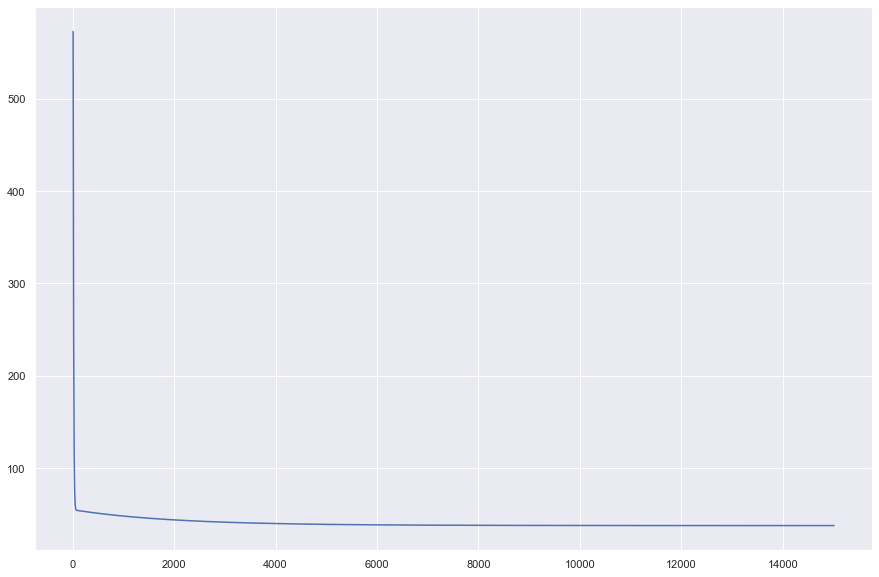

In [291]:
plt.plot(n, avg_loss_list)
plt.show()

In [284]:
import imageio
with imageio.get_writer('gradient_descent_01.gif', mode='I') as writer:
    for filename in img_list:
        image = imageio.imread(filename)
        writer.append_data(image)